In [1]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [265]:
tqdm.pandas()

## YAML FILES CONFIG
files = yaml

## JSON DICTS CONFIG
dicts = json.load(open("../src/EXOTIC_config.json"))

def build_file_exotic_score():

    # READ FILES
    # BIOMART
    biomart = pd.read_csv(
        files["EXOTIC"]["biomart_ensembl_hgnc_refseq"],
        compression="gzip",
        sep="\t",
        low_memory=False,
    )


    refseq = pd.read_parquet(
        files["RefSeq"]["refseq_corrected_lite"],
    )
    refseq.columns = [c.replace("new_", "") for c in refseq.columns]

#     print(refseq)
    
    # FILTER REFSEQ => MI & Multi CDS
    refseq = refseq.loc[(refseq["mRNA_nb_total"] > 1) & (refseq["CDS_count"] > 1) & (refseq['Ratio_num'] < 1)]
    
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])
    
    
    biomart = (
        biomart[["Gene stable ID", "HGNC ID", "Gene name"]]
        .rename(
            {"Gene stable ID": "ENSG", "HGNC ID": "HGNC", "Gene name": "Gene"},
            axis=1,
        )
        .drop_duplicates()
    )
    biomart["HGNC"] = biomart["HGNC"].str.replace("HGNC:", "")

    # MERGE IDS
    refseq = pd.merge(refseq, biomart, on="Gene")
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])

    refseq = refseq.dropna(subset=["HGNC"])
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])

    # CONVERT DTYPE
    refseq["HGNC"] = refseq["HGNC"].astype(int)

    ## pext
    pext_refseq = pd.read_parquet(files['EXOTIC']["pext_refseq_path"])

    # SELECT MULTI-ISOFORM GENES
    multi_mrna_genes = refseq.loc[refseq["mRNA_nb_total"] > 1, "HGNC"].unique()

    # FILTER PEXT TO GET ONLY MULTI-ISO GENES
    pext_refseq["HGNC ID"] = pext_refseq["HGNC ID"].astype(int)
    pext_refseq = pext_refseq.loc[pext_refseq["HGNC ID"].isin(multi_mrna_genes)]

    # ADD COLUMSN TO PEXT
    pext_refseq = pd.merge(
        pext_refseq,
        refseq[["HGNC", "ranges", "Ratio_num", "mRNA_nb", "mRNA_nb_total"]],
        left_on=["HGNC ID", "Exon"],
        right_on=["HGNC", "ranges"],
    )
    pext_refseq["MAP"] = pext_refseq["symbol"] + "_" + pext_refseq["Exon"]

    key_number = 9

    # DROP DUPLICATES
    pext_refseq = pext_refseq.drop_duplicates().sort_values(by="MAP").reset_index(drop=True)
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])
    
    # RENAME COLUMNS & REORDER
    pext_refseq = pext_refseq.rename(dicts["convert_tissue_dict"], axis=1)

    pext_refseq = pext_refseq[
        [
            "symbol",
            "ensg",
            "HGNC",
            "Exon",
            "Ratio_num",
            "mRNA_nb",
            "mRNA_nb_total",
            "MAP",
            "mean_proportion",
            "Adipose - Subcutaneous",
            "Adipose - Visceral (Omentum)",
            "Adrenal Gland",
            "Artery - Aorta",
            "Artery - Coronary",
            "Artery - Tibial",
            "Bladder",
            "Brain - Amygdala",
            "Brain - Anterior cingulate cortex (BA24)",
            "Brain - Caudate (basal ganglia)",
            "Brain - Cerebellar Hemisphere",
            "Brain - Cerebellum",
            "Brain - Cortex",
            "Brain - Frontal Cortex (BA9)",
            "Brain - Hippocampus",
            "Brain - Hypothalamus",
            "Brain - Nucleus accumbens (basal ganglia)",
            "Brain - Putamen (basal ganglia)",
            "Brain - Spinal cord (cervical c-1)",
            "Brain - Substantia nigra",
            "Breast - Mammary Tissue",
            "Cells - Cultured fibroblasts",
            "Cells - EBV-transformed lymphocytes",
            "Cervix - Ectocervix",
            "Cervix - Endocervix",
            "Colon - Sigmoid",
            "Colon - Transverse",
            "Esophagus - Gastroesophageal Junction",
            "Esophagus - Mucosa",
            "Esophagus - Muscularis",
            "Fallopian Tube",
            "Heart - Atrial Appendage",
            "Heart - Left Ventricle",
            "Kidney - Cortex",
            "Liver",
            "Lung",
            "Minor Salivary Gland",
            "Muscle - Skeletal",
            "Nerve - Tibial",
            "Ovary",
            "Pancreas",
            "Pituitary",
            "Prostate",
            "Skin - Not Sun Exposed (Suprapubic)",
            "Skin - Sun Exposed (Lower leg)",
            "Small Intestine - Terminal Ileum",
            "Spleen",
            "Stomach",
            "Testis",
            "Thyroid",
            "Uterus",
            "Vagina",
            "Whole Blood",
        ]
    ]

    # ALTERNATIVE EXONS
    pext_refseq = pext_refseq.loc[pext_refseq["Ratio_num"] < 1].reset_index(drop=True)
    
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])

    # TODO : CHECK HOW TO HANDLE UNEXPRESSED AND FULLY EXPRESSED (0 & 1 MEAN PROP)
    ### WARNING FLAG
    # UNEXPRESSED AND FULLY EXPRESSED EXONS
    pext_refseq = pext_refseq.loc[(pext_refseq["mean_proportion"] > 0.1) & (pext_refseq["mean_proportion"] < 1)].reset_index(drop=True)
    
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])

    # HANDLE NAN VALUES

    pext_refseq = pext_refseq.dropna(subset=list(pext_refseq.columns[key_number:]), how="all")


    # EXOTIC SIGMOID FUNCTION APPLIED TO ZSCORE
    def transform(r):
#         print(r)
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        vfunc = np.vectorize(sigmoid)
        if r.isnull().values.any():
            return pd.Series(vfunc(zscore(r.dropna())), index=r.dropna().index)

        else:
            return pd.Series(vfunc(zscore(r)), index=r.index)

    # EXOTIC SIGMOID FUNCTION APPLIED TO ZSCORE
    def transform_test(x):
#         print(x)
        x = x.dropna()
        def sigmoid(s_x):
            return 1 / (1 + np.exp(-s_x))

        vfunc = np.vectorize(sigmoid)
#         if x.isnull().values.any():
# #             return pd.Series(vfunc([round(e_z * np.abs(e_x - np.median([e for i,e in enumerate(x) if i != j])), 3) for (j, e_x), e_z in zip(enumerate(x.dropna()), zscore(x.dropna()))]), index=x.dropna().index)

#         else:
        result = vfunc([round(e_z * np.abs(e_x - np.median([e for i,e in enumerate(x) if i != j])), 3) for (j, e_x), e_z in zip(enumerate(x), zscore(x))])
        return pd.Series(result, index=x.index)

    # BUILD MATRIX WITH Z-SCORE + SIGMOID
    z_df = pext_refseq[pext_refseq.columns[key_number:]].progress_apply(lambda r: transform_test(r), axis=1)
#     df = pext_refseq.loc[pext_refseq['MAP'] == 'AASDH_57209001-57209132', pext_refseq.columns[key_number:]]
#     z_df = df.progress_apply(lambda r: transform_test(r), axis=1)
    z_df_processed = z_df.copy()
    z_df.columns = list(pext_refseq.columns[key_number:])
    tissue_cols = list(z_df.columns)
    
    # COMPUTE MIN & MAX EXOTIC COLS
    for stat in [min, max]:
        str_stat = stat.__name__
#         print(str_stat)
    
        if str_stat == 'min':
            exotic_stat_convert = 'down'

        elif str_stat == 'max':
            exotic_stat_convert = 'up'
            
        z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)] = z_df.apply(lambda r: stat(r.dropna()), axis=1)
        
        # COMPUTE BINS
        r = np.arange(0.5,1.05,0.05)
        bins = r
        labels = bins.copy()
        labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]


        # COMPUTE BINS COLUMNS
        z_df_processed["EXOTIC_bins_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins, labels=labels_ratio, include_lowest=True)

        z_df_processed['EXOTIC_tissues_{}'.format(exotic_stat_convert)] = z_df_processed.apply(lambda r: [tissue_cols[j] for j, e in enumerate(r) if j < 53 and e == r['EXOTIC_{}'.format(exotic_stat_convert)]], axis=1)

        
        if str_stat == 'min':
            exotic_stat_convert = 'down'
            z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)] = 1 - z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)]
            z_df_processed["EXOTIC_bins_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins, labels=labels_ratio, include_lowest=True)
#         pprint(z_df_processed.to_dict())
        
        # TMP CONCAT EXOTIC SCORE & PEXT VALUES
    ### WARNING FLAG
    # TODO : modify to delete pext part after defining thresholds
    concat_df = pd.concat(
        [
            pext_refseq[pext_refseq.columns[:key_number]].reset_index(drop=True),
            z_df_processed.reset_index(drop=True),
#             pext_refseq[pext_refseq.columns[key_number:]].add_suffix("_pextvalue").reset_index(drop=True),
        ],
        axis=1,
    )
#     print(concat_df)

#     # REMOVE DUPLICATES
#     concat_df = concat_df.drop_duplicates(subset=['MAP']).sort_values(by="MAP").reset_index(drop=True)

#     # OUTPUT INTERMEDIATE FILE
    concat_df.to_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore.parquet")
# #     concat_df.to_excel(self.exotic_files["exotic_path"].replace("parquet", "xlsx"))
    return concat_df
#     print(refseq.Gene.nunique())
#     print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])
#     print(pext_refseq.symbol.nunique())
#     print(pext_refseq.MAP.nunique())
#     print(concat_df)

    
exotic = build_file_exotic_score()
exotic

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


7039
39547
7004
39326
7004
39326


  0%|          | 0/24293 [00:00<?, ?it/s]

6589
28088
6589
28088
6277
24287


100%|██████████| 24293/24293 [01:53<00:00, 214.12it/s]


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24288,ZXDC,ENSG00000070476,28160,126158475-126158570,0.500000,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24289,ZXDC,ENSG00000070476,28160,126160608-126160789,0.500000,1,2,ZXDC_126160608-126160789,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24290,ZXDC,ENSG00000070476,28160,126178496-126178580,0.500000,1,2,ZXDC_126178496-126178580,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24291,ZXDC,ENSG00000070476,28160,126180378-126181063,0.500000,1,2,ZXDC_126180378-126181063,0.34803,0.515245,...,0.497250,0.505250,0.505750,0.441272,0.558728,0.55 - 0.6,[Whole Blood],0.606828,0.6 - 0.65,[Artery - Tibial]


In [266]:
exotic.loc[exotic['EXOTIC_up'].isna() == True]

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up


In [261]:
exotic.loc[exotic['MAP'] == "ARPP21_35725513-35725521"].to_dict()

{'symbol': {1836: 'ARPP21'},
 'ensg': {1836: 'ENSG00000172995'},
 'HGNC': {1836: 16968},
 'Exon': {1836: '35725513-35725521'},
 'Ratio_num': {1836: 0.6},
 'mRNA_nb': {1836: 3},
 'mRNA_nb_total': {1836: 5},
 'MAP': {1836: 'ARPP21_35725513-35725521'},
 'mean_proportion': {1836: 0.47256000000000004},
 'Adipose - Subcutaneous': {1836: nan},
 'Adipose - Visceral (Omentum)': {1836: nan},
 'Adrenal Gland': {1836: nan},
 'Artery - Aorta': {1836: 0.4850044983805899},
 'Artery - Coronary': {1836: 0.7384639204306357},
 'Artery - Tibial': {1836: 0.49900000133333117},
 'Bladder': {1836: nan},
 'Brain - Amygdala': {1836: 0.5204885208851617},
 'Brain - Anterior cingulate cortex (BA24)': {1836: 0.5039999146688512},
 'Brain - Caudate (basal ganglia)': {1836: 0.6891181927915194},
 'Brain - Cerebellar Hemisphere': {1836: 0.45685754723750416},
 'Brain - Cerebellum': {1836: 0.4474448394968623},
 'Brain - Cortex': {1836: 0.49725002772883115},
 'Brain - Frontal Cortex (BA9)': {1836: 0.49900000133333117},
 'B

In [218]:
pext_refseq = pd.read_parquet(files['EXOTIC']["pext_refseq_path"])
pext_refseq["MAP"] = pext_refseq["symbol"] + "_" + pext_refseq["Exon"]


pext_refseq.loc[pext_refseq['MAP'] == 'ZNF257_22270781-22272244'].to_dict()

{'HGNC ID': {82317: 13498.0},
 'symbol': {82317: 'ZNF257'},
 'ensg': {82317: 'ENSG00000197134'},
 'Exon': {82317: '22270781-22272244'},
 'Adipose_Subcutaneous': {82317: 0.35714},
 'Adipose_Visceral_Omentum_': {82317: 0.36364},
 'AdrenalGland': {82317: 0.4},
 'Artery_Aorta': {82317: 0.0},
 'Artery_Coronary': {82317: 0.24241999999999997},
 'Artery_Tibial': {82317: 0.0},
 'Bladder': {82317: 0.23881},
 'Brain_Amygdala': {82317: 0.33333},
 'Brain_Anteriorcingulatecortex_BA24_': {82317: 0.21429},
 'Brain_Caudate_basalganglia_': {82317: 0.33333},
 'Brain_CerebellarHemisphere': {82317: 0.0},
 'Brain_Cerebellum': {82317: 0.0},
 'Brain_Cortex': {82317: 0.0},
 'Brain_FrontalCortex_BA9_': {82317: 0.0},
 'Brain_Hippocampus': {82317: 0.33333},
 'Brain_Hypothalamus': {82317: 0.4},
 'Brain_Nucleusaccumbens_basalganglia_': {82317: 0.36364},
 'Brain_Putamen_basalganglia_': {82317: 0.3},
 'Brain_Spinalcord_cervicalc_1_': {82317: 0.29412},
 'Brain_Substantianigra': {82317: 0.6511600000000001},
 'Breast_Ma

In [219]:
exotic.loc[exotic['MAP'] == 'ZNF257_22270781-22272244'].to_dict()

{'symbol': {23794: 'ZNF257'},
 'ensg': {23794: 'ENSG00000197134'},
 'HGNC': {23794: 13498},
 'Exon': {23794: '22270781-22272244'},
 'Ratio_num': {23794: 0.3333333333333333},
 'mRNA_nb': {23794: 1},
 'mRNA_nb_total': {23794: 3},
 'MAP': {23794: 'ZNF257_22270781-22272244'},
 'mean_proportion': {23794: 0.31128},
 'Adipose - Subcutaneous': {23794: nan},
 'Adipose - Visceral (Omentum)': {23794: nan},
 'Adrenal Gland': {23794: nan},
 'Artery - Aorta': {23794: nan},
 'Artery - Coronary': {23794: nan},
 'Artery - Tibial': {23794: nan},
 'Bladder': {23794: nan},
 'Brain - Amygdala': {23794: nan},
 'Brain - Anterior cingulate cortex (BA24)': {23794: nan},
 'Brain - Caudate (basal ganglia)': {23794: nan},
 'Brain - Cerebellar Hemisphere': {23794: nan},
 'Brain - Cerebellum': {23794: nan},
 'Brain - Cortex': {23794: nan},
 'Brain - Frontal Cortex (BA9)': {23794: nan},
 'Brain - Hippocampus': {23794: nan},
 'Brain - Hypothalamus': {23794: nan},
 'Brain - Nucleus accumbens (basal ganglia)': {23794: 

In [185]:
exotic.EXOTIC_tissues_up

0        [Adipose - Subcutaneous, Adipose - Visceral (O...
1        [Adipose - Subcutaneous, Adipose - Visceral (O...
2        [Adipose - Subcutaneous, Adipose - Visceral (O...
3        [Adipose - Subcutaneous, Adipose - Visceral (O...
4        [Adipose - Subcutaneous, Adipose - Visceral (O...
                               ...                        
24282                                                  NaN
24283                                                  NaN
24284                                                  NaN
24285                                                  NaN
24286                                                  NaN
Name: EXOTIC_tissues_up, Length: 24287, dtype: object

In [166]:
len_tissue_cols = 53

for j,e in enumerate(exotic.loc[0][:len_tissue_cols+1]):
    print(j,e)

NameError: name 'len_tissue_cols' is not defined

In [155]:
exotic.to_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore.parquet")


In [208]:
exotic.symbol.nunique()

6277

In [2]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore.parquet")
exotic


,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24288,ZXDC,ENSG00000070476,28160,126158475-126158570,0.500000,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24289,ZXDC,ENSG00000070476,28160,126160608-126160789,0.500000,1,2,ZXDC_126160608-126160789,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24290,ZXDC,ENSG00000070476,28160,126178496-126178580,0.500000,1,2,ZXDC_126178496-126178580,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24291,ZXDC,ENSG00000070476,28160,126180378-126181063,0.500000,1,2,ZXDC_126180378-126181063,0.34803,0.515245,...,0.497250,0.505250,0.505750,0.441272,0.558728,0.55 - 0.6,[Whole Blood],0.606828,0.6 - 0.65,[Artery - Tibial]


In [70]:
exotic.loc[exotic['EXOTIC_bins_min'] == '0.0 - 0.05']

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_min,EXOTIC_bins_min,EXOTIC_max,EXOTIC_bins_max
55,ABCB9,ENSG00000150967,50,123425354-123425542,0.666667,2,3,ABCB9_123425354-123425542,0.57383,0.509249,...,0.50000,0.512997,0.497500,0.50000,0.496750,0.028554,0.028554,0.0 - 0.05,0.603005,0.6 - 0.65
353,ACSL5,ENSG00000197142,16526,114154705-114154860,0.500000,1,2,ACSL5_114154705-114154860,0.83088,0.500250,...,0.50025,0.033118,0.500000,0.49675,0.500500,0.499500,0.033118,0.0 - 0.05,0.574198,0.55 - 0.6
586,AFAP1L1,ENSG00000157510,26714,148685869-148685967,0.750000,3,4,AFAP1L1_148685869-148685967,0.69661,0.503250,...,0.50100,0.301745,0.500250,0.50125,0.487503,0.046486,0.046486,0.0 - 0.05,0.577861,0.55 - 0.6
587,AFAP1L1,ENSG00000157510,26714,148691675-148691767,0.750000,3,4,AFAP1L1_148691675-148691767,0.69661,0.503250,...,0.50100,0.301745,0.500250,0.50125,0.487503,0.046486,0.046486,0.0 - 0.05,0.577861,0.55 - 0.6
588,AFAP1L1,ENSG00000157510,26714,148695384-148695477,0.750000,3,4,AFAP1L1_148695384-148695477,0.69661,0.503250,...,0.50100,0.301745,0.500250,0.50125,0.487503,0.046486,0.046486,0.0 - 0.05,0.577861,0.55 - 0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23371,ZC2HC1C,ENSG00000119703,20354,75544235-75544239,0.666667,2,3,ZC2HC1C_75544235-75544239,0.72513,0.500000,...,0.50000,0.449918,0.464808,0.50000,0.500000,0.041408,0.041408,0.0 - 0.05,0.604201,0.6 - 0.65
23456,ZEB1,ENSG00000148516,11642,31749966-31750166,0.500000,5,10,ZEB1_31749966-31750166,0.90796,0.494500,...,0.49800,0.006581,0.492501,0.50025,0.500250,0.516993,0.006581,0.0 - 0.05,0.516993,0.5 - 0.55
23482,ZFP64,ENSG00000020256,15940,50768685-50769967,0.600000,3,5,ZFP64_50768685-50769967,0.76057,0.500250,...,0.50325,0.044235,0.507499,0.50125,0.496500,0.483007,0.044235,0.0 - 0.05,0.513497,0.5 - 0.55
24237,ZNF823,ENSG00000197933,30936,11836016-11836142,0.500000,1,2,ZNF823_11836016-11836142,0.96227,0.498750,...,0.50000,0.500000,0.500000,0.50000,0.498750,0.000963,0.000963,0.0 - 0.05,0.500500,0.5 - 0.55


In [74]:
exotic.loc[586].to_dict()

{'symbol': 'AFAP1L1',
 'ensg': 'ENSG00000157510',
 'HGNC': 26714,
 'Exon': '148685869-148685967',
 'Ratio_num': 0.75,
 'mRNA_nb': 3,
 'mRNA_nb_total': 4,
 'MAP': 'AFAP1L1_148685869-148685967',
 'mean_proportion': 0.6966100000000001,
 'Adipose - Subcutaneous': 0.5032499542299401,
 'Adipose - Visceral (Omentum)': 0.5022499848126231,
 'Adrenal Gland': 0.49925000056249946,
 'Artery - Aorta': 0.5219858136524729,
 'Artery - Coronary': 0.5167437369156502,
 'Artery - Tibial': 0.5505764354778004,
 'Bladder': 0.5177425472777281,
 'Brain - Amygdala': 0.4995000001666665,
 'Brain - Anterior cingulate cortex (BA24)': 0.4995000001666665,
 'Brain - Caudate (basal ganglia)': 0.5,
 'Brain - Cerebellar Hemisphere': 0.49750002083312506,
 'Brain - Cerebellum': 0.48525427724026554,
 'Brain - Cortex': 0.4950001666600003,
 'Brain - Frontal Cortex (BA9)': 0.5002499999791666,
 'Brain - Hippocampus': 0.5002499999791666,
 'Brain - Hypothalamus': 0.5019999893334016,
 'Brain - Nucleus accumbens (basal ganglia)': 0.

In [67]:
exotic['EXOTIC_bins_min'].value_counts()

0.4 - 0.45    6794
0.45 - 0.5    4962
0.35 - 0.4    3714
0.3 - 0.35    2262
0.25 - 0.3    1270
0.2 - 0.25     997
0.15 - 0.2     714
0.1 - 0.15     465
0.05 - 0.1     352
0.0 - 0.05     342
Name: EXOTIC_bins_min, dtype: int64

In [68]:
exotic['EXOTIC_bins_max'].value_counts()

0.5 - 0.55    6971
0.55 - 0.6    5919
0.6 - 0.65    3706
0.65 - 0.7    2178
0.7 - 0.75    1396
0.75 - 0.8     661
0.8 - 0.85     413
0.85 - 0.9     355
0.9 - 0.95     166
0.95 - 1.0     107
Name: EXOTIC_bins_max, dtype: int64

In [107]:
max(exotic.EXOTIC_down)

0.999250234484809

In [47]:
pd.read_excel('/gstock/EXOTIC/data/EXOTIC/circular_barplot_total.xlsx')

,Tissue,bronze,gold,silver,Total,log_value,group,Abbrev,Color,Samples
0,Adipose - Subcutaneous,44,0,5,49,1.690196,A,ADPSBQ,#FF6600,581.0
1,Adipose - Visceral (Omentum),22,0,3,25,1.397940,A,ADPVSC,#FFAA00,469.0
2,Adrenal Gland,111,1,25,137,2.136721,A,ADRNLG,#33DD33,233.0
3,Artery - Aorta,128,1,6,135,2.130334,A,ARTAORT,#FF5555,387.0
4,Artery - Coronary,32,0,4,36,1.556303,A,ARTCRN,#FFAA99,213.0
5,Artery - Tibial,358,1,28,387,2.587711,A,ARTTBL,#FF0000,584.0
6,Bladder,268,10,52,330,2.518514,A,BLADDER,#A90000,NaN
7,Brain - Amygdala,246,1,6,253,2.403121,A,BRNAMY,#EEEE00,129.0
8,Brain - Anterior cingulate cortex (BA24),228,0,4,232,2.365488,A,BRNACC,#EEEE00,147.0
9,Brain - Caudate (basal ganglia),77,0,9,86,1.934498,A,BRNCDT,#EEEE00,194.0


In [53]:
up = exotic.loc[exotic['EXOTIC_up'] > 0.8, ['EXOTIC_tissues_up']].explode('EXOTIC_tissues_up').value_counts()
up.name = 'Up'
up = pd.DataFrame(up)
down = exotic.loc[exotic['EXOTIC_down'] > 0.8, ['EXOTIC_tissues_down']].explode('EXOTIC_tissues_down').value_counts()
down.name = 'Down'
down = pd.DataFrame(down)
concat_up_down = pd.concat([down, up], axis=1).fillna(0).round(0)
concat_up_down['Sum'] = concat_up_down.sum(axis=1)
concat_up_down['log_value'] = concat_up_down['Sum'].apply(np.log10)
concat_up_down = concat_up_down.reset_index().rename({'level_0' : 'Tissue'}, axis=1)

old_sun_excel = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/circular_barplot_total.xlsx')

concat_up_down = pd.merge(old_sun_excel[['Tissue', 'group', 'Abbrev', 'Color']], concat_up_down, on='Tissue')

concat_up_down.to_excel('/gstock/EXOTIC/data/EXOTIC/exotic_sun_tissues.xlsx', index=False)

concat_up_down

# exotic[['EXOTIC_tissues_up']]

,Tissue,group,Abbrev,Color,Down,Up,Sum,log_value
0,Adipose - Subcutaneous,A,ADPSBQ,#FF6600,13,27.0,40.0,1.602060
1,Adipose - Visceral (Omentum),A,ADPVSC,#FFAA00,10,4.0,14.0,1.146128
2,Adrenal Gland,A,ADRNLG,#33DD33,13,4.0,17.0,1.230449
3,Artery - Aorta,A,ARTAORT,#FF5555,18,28.0,46.0,1.662758
4,Artery - Coronary,A,ARTCRN,#FFAA99,7,22.0,29.0,1.462398
5,Artery - Tibial,A,ARTTBL,#FF0000,21,45.0,66.0,1.819544
6,Bladder,A,BLADDER,#A90000,19,19.0,38.0,1.579784
7,Brain - Amygdala,A,BRNAMY,#EEEE00,17,9.0,26.0,1.414973
8,Brain - Anterior cingulate cortex (BA24),A,BRNACC,#EEEE00,11,27.0,38.0,1.579784
9,Brain - Caudate (basal ganglia),A,BRNCDT,#EEEE00,10,9.0,19.0,1.278754


In [62]:
ridge_up = exotic[['EXOTIC_tissues_up', 'EXOTIC_up', 'MAP', 'symbol']].explode('EXOTIC_tissues_up')
ridge_up.columns = ['Tissue', 'EXOTIC_up', 'MAP', 'symbol']
ridge_up.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_up_Rdata.xlsx', index=False)

ridge_down = exotic[['EXOTIC_tissues_down', 'EXOTIC_down', 'MAP', 'symbol']].explode('EXOTIC_tissues_down')
ridge_down.columns = ['Tissue', 'EXOTIC_down', 'MAP', 'symbol']
ridge_down.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_down_Rdata.xlsx', index=False)

In [64]:
ridge_down

,Tissue,EXOTIC_down,MAP,symbol
0,Brain - Cerebellar Hemisphere,0.713205,A2ML1_8975248-8975309,A2ML1
1,Brain - Cerebellar Hemisphere,0.713205,A2ML1_8975778-8975961,A2ML1
2,Brain - Cerebellar Hemisphere,0.713205,A2ML1_8976316-8976478,A2ML1
3,Brain - Cerebellar Hemisphere,0.713205,A2ML1_8982323-8982375,A2ML1
4,Brain - Cerebellar Hemisphere,0.713205,A2ML1_8987258-8987278,A2ML1
...,...,...,...,...
24288,Brain - Nucleus accumbens (basal ganglia),0.542398,ZXDC_126158475-126158570,ZXDC
24289,Brain - Nucleus accumbens (basal ganglia),0.542398,ZXDC_126160608-126160789,ZXDC
24290,Brain - Nucleus accumbens (basal ganglia),0.542398,ZXDC_126178496-126178580,ZXDC
24291,Whole Blood,0.558728,ZXDC_126180378-126181063,ZXDC


(-0.25, 9.65)
Rectangle(xy=(0, 0), width=-0.4, height=5408, angle=0)
Rectangle(xy=(1, 0), width=-0.4, height=7188, angle=0)
Rectangle(xy=(2, 0), width=-0.4, height=4042, angle=0)
Rectangle(xy=(3, 0), width=-0.4, height=2585, angle=0)
Rectangle(xy=(4, 0), width=-0.4, height=1494, angle=0)
Rectangle(xy=(5, 0), width=-0.4, height=1159, angle=0)
Rectangle(xy=(6, 0), width=-0.4, height=814, angle=0)
Rectangle(xy=(7, 0), width=-0.4, height=605, angle=0)
Rectangle(xy=(8, 0), width=-0.4, height=469, angle=0)
Rectangle(xy=(9, 0), width=-0.4, height=529, angle=0)
Rectangle(xy=(0, 0), width=0.4, height=7777, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=6267, angle=0)
Rectangle(xy=(2, 0), width=0.4, height=4025, angle=0)
Rectangle(xy=(3, 0), width=0.4, height=2377, angle=0)
Rectangle(xy=(4, 0), width=0.4, height=1551, angle=0)
Rectangle(xy=(5, 0), width=0.4, height=803, angle=0)
Rectangle(xy=(6, 0), width=0.4, height=538, angle=0)
Rectangle(xy=(7, 0), width=0.4, height=456, angle=0)
Rectangle(x

Text(0, 0.5, 'Invert cumsum ratio')

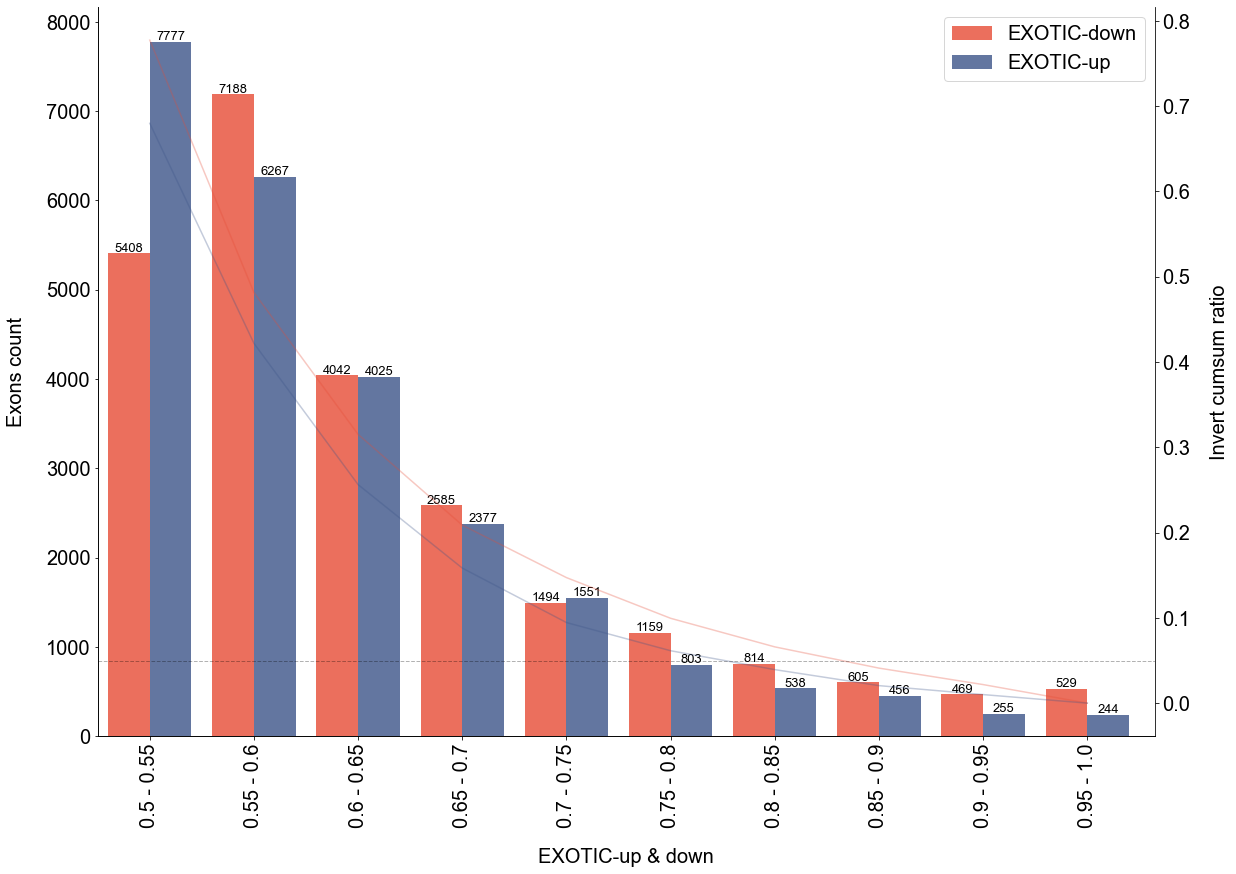

In [108]:
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + 20
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(int(value), 0)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


plt.rcParams.update({'font.size': 20})

f, ax = plt.subplots(figsize=(16,12))        
exotic['EXOTIC_bins_down'].value_counts().sort_index().plot.bar(alpha=0.8, color='#E64B35FF', width=-0.4, align='edge')
# exotic.EXOTIC_median.plot.hist(alpha=0.3, color='g', rwidth=0.8)
exotic['EXOTIC_bins_up'].value_counts().sort_index().plot.bar(alpha=0.8, width=0.4, color='#3C5488FF', align='edge')
plt.legend()
# ax2.set_ylim(ax.get_ylim())
print(ax.get_xlim())
ax.set_xlim(-0.5,9.65)

show_values_on_bars(ax)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.tight_layout()

ax.set_xlabel('EXOTIC-up & down', labelpad=20)
ax.set_ylabel('Exons count', labelpad=20)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
L=plt.legend()
L.get_texts()[0].set_text('EXOTIC-down')
L.get_texts()[1].set_text('EXOTIC-up')
# ax.set_xticks(np.arange(0.5,1,0.05))
print(list(ax.get_xticklabels()))
# ax.set_xticklabels([str(e) for e in np.arange(0.5,1.05,0.05)])

ax2 = ax.twinx()

tmp_cumsum_df = pd.concat([pd.DataFrame(exotic['EXOTIC_bins_down'].value_counts().sort_index()), pd.DataFrame(exotic['EXOTIC_bins_up'].value_counts().sort_index())], axis=1)
tmp_cumsum_df['Cumsum_down'] = (tmp_cumsum_df['EXOTIC_bins_down'].sum() - tmp_cumsum_df['EXOTIC_bins_down'].cumsum()) / tmp_cumsum_df['EXOTIC_bins_down'].sum()
tmp_cumsum_df['Cumsum_up'] = (tmp_cumsum_df['EXOTIC_bins_up'].sum() - tmp_cumsum_df['EXOTIC_bins_up'].cumsum()) / tmp_cumsum_df['EXOTIC_bins_up'].sum()
tmp_cumsum_df.Cumsum_down.plot.line(color='#E64B35FF', alpha=0.3, ax=ax2)
tmp_cumsum_df.Cumsum_up.plot.line(color='#3C5488FF', alpha=0.3, ax=ax2)
# ax2.spines['right'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.axhline(0.05, color='black', linestyle='--', lw=1, alpha=0.3)
ax2.set_ylabel('Invert cumsum ratio', labelpad=20)


# # COMPUTE BINS
# bins = np.arange(min(exotic.EXOTIC_down), max(exotic.EXOTIC_up)+0.05, 0.05)
# labels = bins.copy()
# labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]


# xticks = ax.set_xticks(np.arange(min(exotic.EXOTIC_down), max(exotic.EXOTIC_up)+0.05, 0.05))
# ax.set_xticks(ax.get_xticks()[:-1])
# plt.xlim(0.45,1)


In [193]:
pprint(exotic.loc[(exotic.EXOTIC_down > 0.99), 'symbol'].unique().tolist())

['ALPL',
 'COPRS',
 'DENND2A',
 'DUSP19',
 'HDAC9',
 'KIFC3',
 'KLF5',
 'LSR',
 'NDRG3',
 'NRXN3',
 'PID1',
 'PKIB',
 'RAB3IL1',
 'RAPH1',
 'RNF38',
 'SH3BGR',
 'SHROOM2',
 'SKAP2',
 'SLC35E4',
 'SPATA6',
 'SYBU',
 'TEAD4',
 'TPD52L1',
 'ZEB1',
 'ZNF823']


In [40]:
z_df.loc[12]

Adipose - Subcutaneous                       0.498500
Adipose - Visceral (Omentum)                 0.498500
Adrenal Gland                                0.498500
Artery - Aorta                               0.498500
Artery - Coronary                            0.498500
Artery - Tibial                              0.498500
Bladder                                      0.496000
Brain - Amygdala                             0.505000
Brain - Anterior cingulate cortex (BA24)     0.526226
Brain - Caudate (basal ganglia)              0.528469
Brain - Cerebellar Hemisphere                0.795760
Brain - Cerebellum                           0.711771
Brain - Cortex                               0.557001
Brain - Frontal Cortex (BA9)                 0.548101
Brain - Hippocampus                          0.503750
Brain - Hypothalamus                         0.509999
Brain - Nucleus accumbens (basal ganglia)    0.514246
Brain - Putamen (basal ganglia)              0.532205
Brain - Spinal cord (cervica

In [39]:
pext_refseq.loc[12].to_dict()

{'symbol': 'A2ML1',
 'ensg': 'ENSG00000166535',
 'HGNC': 23336,
 'Exon': '8997768-8997770',
 'Ratio_num': 0.5,
 'mRNA_nb': 1,
 'mRNA_nb_total': 2,
 'MAP': 'A2ML1_8997768-8997770',
 'mean_proportion': 0.12322000000000001,
 'Adipose - Subcutaneous': 0.0,
 'Adipose - Visceral (Omentum)': 0.0,
 'Adrenal Gland': 0.0,
 'Artery - Aorta': 0.0,
 'Artery - Coronary': 0.0,
 'Artery - Tibial': 0.0,
 'Bladder': 0.034483,
 'Brain - Amygdala': 0.14658,
 'Brain - Anterior cingulate cortex (BA24)': 0.2093,
 'Brain - Caudate (basal ganglia)': 0.21463000000000002,
 'Brain - Cerebellar Hemisphere': 0.54745,
 'Brain - Cerebellum': 0.45946000000000004,
 'Brain - Cortex': 0.26923,
 'Brain - Frontal Cortex (BA9)': 0.25385,
 'Brain - Hippocampus': 0.1413,
 'Brain - Hypothalamus': 0.16522,
 'Brain - Nucleus accumbens (basal ganglia)': 0.17808,
 'Brain - Putamen (basal ganglia)': 0.22263000000000002,
 'Brain - Spinal cord (cervical c-1)': 0.0,
 'Brain - Substantia nigra': 0.16387000000000002,
 'Breast - Mammary 

# EXOTIC & pext distribution

## Compute stuff

In [224]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test['pext_min_max_diff'] = test['pext_EXOTIC_max_median'] - test['pext_EXOTIC_min_median']
test

,symbol,MAP,EXOTIC_min,EXOTIC_tissues_corrected_min,EXOTIC_pext_associated_min,EXOTIC_max,EXOTIC_tissues_corrected_max,EXOTIC_pext_associated_max,pext_EXOTIC_min_median,pext_EXOTIC_max_median,pext_min_max_diff
0,A2ML1,A2ML1_8975248-8975309,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.17518,1.00000,0.82482
1,A2ML1,A2ML1_8975778-8975961,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.17518,1.00000,0.82482
2,A2ML1,A2ML1_8976316-8976478,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.17518,1.00000,0.82482
3,A2ML1,A2ML1_8982323-8982375,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.17518,1.00000,0.82482
4,A2ML1,A2ML1_8987258-8987278,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.17518,1.00000,0.82482
...,...,...,...,...,...,...,...,...,...,...,...
27533,ZXDC,ZXDC_126158475-126158570,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],0.912582,[Muscle - Skeletal],[0.34009],0.11398,0.34009,0.22611
27534,ZXDC,ZXDC_126160608-126160789,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],0.912582,[Muscle - Skeletal],[0.34009],0.11398,0.34009,0.22611
27535,ZXDC,ZXDC_126178496-126178580,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],0.912582,[Muscle - Skeletal],[0.34009],0.11398,0.34009,0.22611
27536,ZXDC,ZXDC_126180378-126181063,0.139039,[Whole Blood],[0.20951999999999998],0.910061,[Artery - Tibial],[0.52384],0.20952,0.52384,0.31432


## Fig X - Diff EXOTIC-min & max 

[0.7794307601197143]


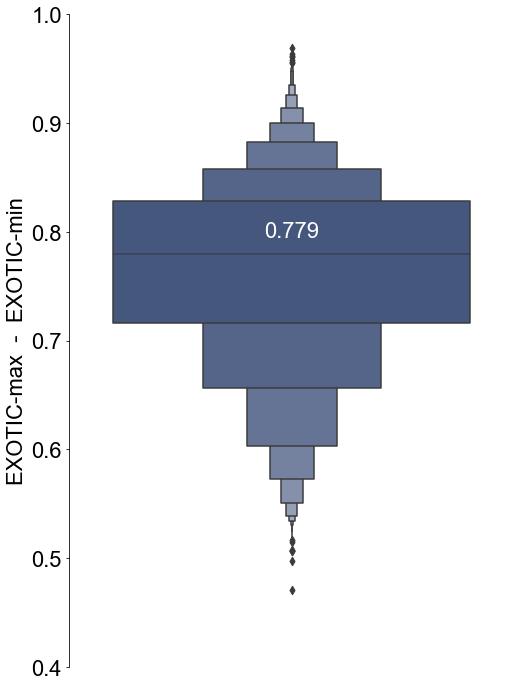

In [221]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['EXOTIC_min_max_diff'] = test['EXOTIC_max'] - test['EXOTIC_min']
plt.figure(figsize=(8,12))
b = sns.boxenplot(data=test, y='EXOTIC_min_max_diff', color='#3C5488FF')
plt.ylabel('EXOTIC-max  -  EXOTIC-min')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
plt.ylim(0.4,1)

data = test
x, y = 'MAP', 'EXOTIC_min_max_diff'
medians = [data[y].median()]
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Diff pext EXOTIC-min & max 

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[0.33539]


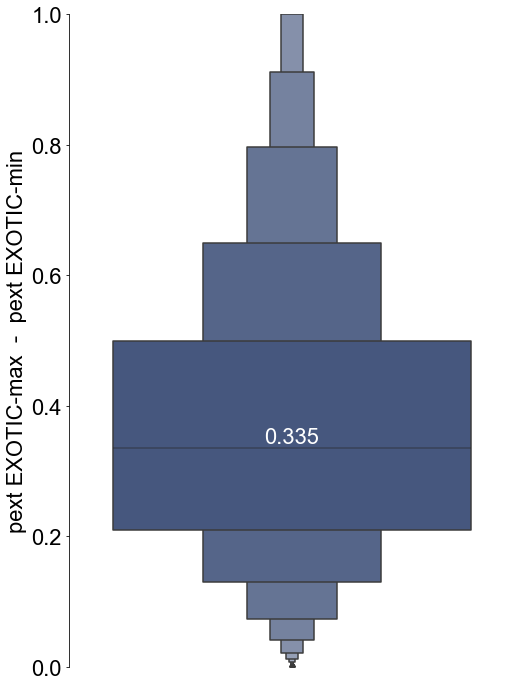

In [228]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test['pext_min_max_diff'] = test['pext_EXOTIC_max_median'] - test['pext_EXOTIC_min_median']

plt.figure(figsize=(8,12))
b = sns.boxenplot(data=test, y='pext_min_max_diff', color='#3C5488FF')
plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
plt.ylim(0,1)

data = test
x, y = 'MAP', 'pext_min_max_diff'
medians = [data[y].median()]
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Distribution pext + EXOTIC-min

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[0.09737365590096414, 0.27329000000000003]


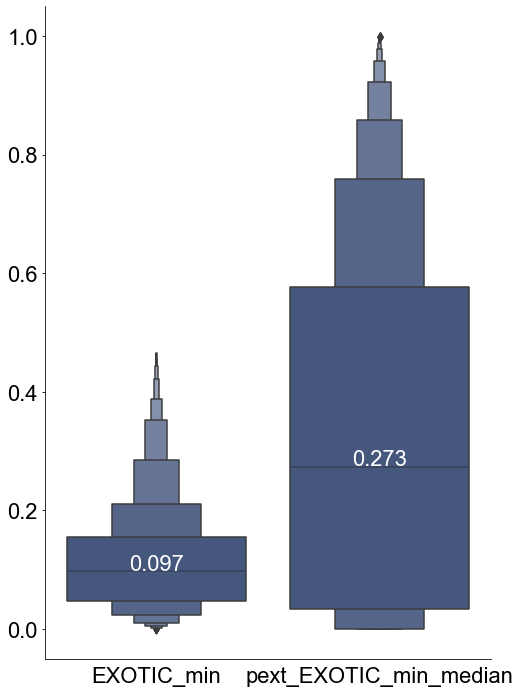

In [239]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test = test[['MAP', 'EXOTIC_min', 'pext_EXOTIC_min_median',]].melt(id_vars='MAP', value_vars=['EXOTIC_min', 'pext_EXOTIC_min_median'])

f, ax=  plt.subplots(figsize=(8,12))
b = sns.boxenplot(data=test, x='variable', y='value', color='#3C5488FF')
# plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
plt.xlabel('')
plt.ylabel('')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
# b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
# plt.ylim(0,1)

data = test
x, y = 'MAP', 'value'
medians = data.groupby('variable')[y].median().values.tolist()
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Distribution pext + EXOTIC-max

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[0.8993509559734316, 0.7934100000000001]


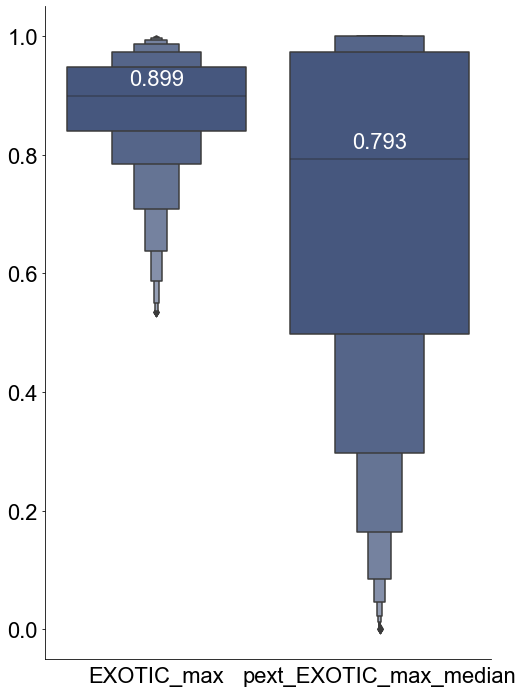

In [240]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test = test[['MAP', 'EXOTIC_max', 'pext_EXOTIC_max_median',]].melt(id_vars='MAP', value_vars=['EXOTIC_max', 'pext_EXOTIC_max_median'])

f, ax=  plt.subplots(figsize=(8,12))
b = sns.boxenplot(data=test, x='variable', y='value', color='#3C5488FF')
# plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
plt.xlabel('')
plt.ylabel('')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
# b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
# plt.ylim(0,1)

data = test
x, y = 'MAP', 'value'
medians = data.groupby('variable')[y].median().values.tolist()
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
